In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
from scipy.integrate import simps
from matplotlib.ticker import ScalarFormatter
from IPython.display import display
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'  

In [2]:
#Fixed parameter values
pi = 1710; 
#beta1 =1.72;
mu =1/(83*365); 
eps =0.33;   #Youngji paper
tau = 0.8; tau = 0.8;
psi = 0.5; 
phi1, phi2 = 1/180, 1/180
h1= 0.0012; 
h2 = (1-0.74)*h1;
rho = 1/14; 
rhot =1/10; rhoh =1/10;
#rhot =1/10; rhoh =1/7;
eta1= 0.71; eta2= 0.41; eta4= 0.85; eta3 = 0.46;
a = 1/3  # fixed to be 3 days  

theta = 0.5 # parameter adjusting reduced perception risk (assumed)
delta = 0.8  # proportion of tested people who quarantine/adhere to protective measures (assumed)
alpha1, alpha2 = 0.5, 0.5  # parameters which shows to which information people are more concerned

# Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
# D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
D = 5;
B = 10
Fmax = 0.027; F10 = 0.0029; F20 = (0.9)*F10; 
Tmax = 0.5; T10 = 0.03; T20 = 0.03    #Tmax is adjusted to have a good fit

# Fitted parameters
k1=  0.51
beta1=  0.67
beta2=  0.39
xi=  0.99
d1 =0.000071; d2 = 0.000073;  
c1, c2 = 1, 1

In [3]:
# Initial conditions
NN = 51815808
V2_0 = 2891 #int(0.87*Data_Omicron['new_vaccinations'].iloc[0])
V1_0 = 431; #int(0.13*Data_Omicron['new_vaccinations'].iloc[0])
E2_0 = 352645 #int(0.87*20*NewCases.iloc[0])
A2_0 = 70529 #int(0.2*E2_0)
I2_0 = 282116  #int(0.8*E2_0)
IT2_0 = 17632 #int(0.87*NewCases.iloc[0])
E1_0 = 52694 #int(0.13*20*NewCases.iloc[0])  # 0.13 indicates that 13% of the total population is in the first dynamics
A1_0 = 10538 #int(0.2*E1_0)
I1_0 = 42155 #int(0.8*E1_0)
IT1_0 = 2634 #int(0.13*NewCases.iloc[0])
H_0 = 202  # ICU
R_0 = 200
Dth_0 = 15
S2_0 = 40000000 # 0.9*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S3_0 = 4365186 #0.1*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S1_0 = NN-(S2_0 + S3_0 + V1_0 + V2_0 + E1_0 + E2_0 + A1_0 + A2_0 + I1_0 + I2_0 + IT1_0 + IT2_0 + H_0 + R_0)
MV_0 = k1*((I1_0 + I2_0 + IT1_0 + IT2_0 + H_0)/NN)
MN_0 = k1*((H_0 + d1*(I1_0+I2_0) + d2*H_0)/NN)

In [4]:
def sir_model(x,t):
    
    S1, S2, S3, V1, V2, E1, E2, A1, A2, I1, I2, I_T1, I_T2, H, R, Dth, MV, MN  = x
    dx = np.zeros(18)
    N= S1 + S2+ S3 + V1 + V2 + E1 + E2 + A1 + A2 + I1 + I2 + I_T1 + I_T2 + H + R
    
    T1 = c1*T10 + c2*(Tmax - T10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(B*MN)/(1+B*MN) )
    F1 = c1*F10 + c2*(Fmax - F10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(B*MN)/(1+B*MN))
    
    T2 = c1*T10 + c2*(Tmax - T10)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*B*MN)/(1+theta*B*MN))
    F2 = c1*F20 + c2*(Fmax - F20)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*B*MN)/(1+theta*B*MN))
    
    L1 = beta1*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    L2 = beta2*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    
    dx[0] = pi-(F1 +L1 +mu)*S1
    dx[1] = phi1*V1 -((1-eta2)*L2+F2+mu)*S2
    dx[2] = phi2*R-((1-eta3)*L2+F2+mu)*S3
    dx[3] = F1*S1-phi1*V1-(1-eta1)*L2*V1-mu*V1
    dx[4] = F2*S2+F2*S3-(1-eta4)*L2*V2-mu*V2
    dx[5] = L1*S1-(eps+mu)*E1
    dx[6] = (1-eta1)*L2*V1+(1-eta4)*L2*V2+L2*((1-eta2)*S2+(1-eta3)*S3)-(mu+eps)*E2
    dx[7] = (1-tau)*eps*E1-xi*T1*A1-(rho+mu)*A1
    dx[8] = (1-tau)*eps*E2-xi*T2*A2-(rho+mu)*A2
    dx[9] = tau*eps*E1-T1*I1-(rho+d1+mu)*I1
    dx[10] = tau*eps*E2-T2*I2-(rho+d1+mu)*I2
    dx[11] = xi*T1*A1+T1*I1-(rhot+h1+mu)*I_T1
    dx[12] = xi*T2*A2+T2*I2-(rhot+h2+mu)*I_T2
    dx[13] = h1*I_T1+h2*I_T2-rhoh*H-(d2+mu)*H
    dx[14] = rho*(A1+A2+I1+I2)+rhot*(I_T1+I_T2)+rhoh*H-(phi2+mu)*R
    dx[15] = d1*(I1+I2)+d2*H
    dx[16] = a*(k1*((I_T1+I_T2+I1+I2+H)/NN)-MV) 
    dx[17] = a*(k1*((H + d1*(I1 + I2) + d2*H)/NN)-MN)
    return dx

In [5]:
t = np.linspace(0,120,120)
x0 = [S1_0, S2_0, S3_0, V1_0, V2_0, E1_0, E2_0, A1_0, A2_0, I1_0, I2_0, IT1_0, IT2_0, H_0, R_0, Dth_0, MV_0, MN_0]

In [6]:
Cum_vacc_m = np.zeros(len(t));           Cum_vacc_v = np.zeros(len(t))
Cum_tested_m = np.zeros(len(t));         Cum_tested_v = np.zeros(len(t))

Cum_mandatory_infectious1 = np.zeros(len(t)); 
Cum_infectious1 = np.zeros(len(t));     
Cum_hosp1 = np.zeros(len(t));  
Cum_tested1 = np.zeros(len(t));
Cum_death1 = np.zeros(len(t));

Cum_tested_m[0] = (IT1_0 + IT2_0)/2; 
Cum_tested_v[0] = (IT1_0 + IT2_0)/2; 
Cum_vacc_m[0] = (V1_0 + V2_0)/2; 
Cum_vacc_v[0] = (V1_0 + V2_0)/2; 


          
for c2 in [0,1]:
    
    ret = odeint(sir_model, x0, t)
    
    Cum_infectious1[0] =  I1_0 + I2_0;  Cum_hosp1[0] = H_0; Cum_tested1[0] = IT1_0 + IT2_0; Cum_death1[0] = Dth_0
    
    for i0 in range(1,len(t)):
    
        Cum_infectious1[i0] =  I1_0 + I2_0 + np.trapz(tau*eps*(ret[:i0+1,5] + ret[:i0+1,6] ), t[:i0+1])
        Cum_hosp1[i0] = H_0 + np.trapz(h1*ret[:i0+1,11] + h2*ret[:i0+1,12], t[:i0+1])
        Cum_death1[i0] = Dth_0 + np.trapz(d1*(ret[:i0+1,15]+ ret[:i0+1,15])+d2*ret[:i0+1,13], t[:i0+1])
         
        
        Test1_m = c1*T10 
        Test1_v = c2*(Tmax - T10)*(alpha1* np.divide(D*ret[:i0+1,16],(1+D*ret[:i0+1,16])) + (1-alpha1)* np.divide(B*ret[:i0+1,17],(1+B*ret[:i0+1,17]))) 
        
        Test2_m = c1*T10 
        Test2_v = c2*(Tmax -T10)*(alpha2* np.divide(theta*D*ret[:i0+1,16],(1+theta*D*ret[:i0+1,16])) + (1-alpha2)* np.divide(theta*B*ret[:i0+1,17],(1+theta*B*ret[:i0+1,17])))
    
        #Cum_tested1[i0] = IT1_0 + IT2_0 + np.trapz(np.multiply(Test1_m + Test1_v,ret[:i0+1,9]) + np.multiply(Test2_m + Test2_v, ret[:i0+1,10]),t[:i0+1]) 
        
        Vac1_m = c1*F10 
        Vac1_v = c2*(Fmax -F10)*(alpha1*np.divide(D*ret[:i0+1,16],(1+D*ret[:i0+1,16])) + (1-alpha1)*np.divide(B*ret[:i0+1,17],(1+B*ret[:i0+1,17])))
        
        Vac2_m = c1*F20 
        Vac2_v = c2*(Fmax -F20)*(alpha2* np.divide(theta*D*ret[:i0+1,16],(1+theta*D*ret[:i0+1,16])) + (1-alpha2)* np.divide(theta*B*ret[:i0+1,17],(1+theta*B*ret[:i0+1,17])))
        
        
        Cum_vacc_m[i0] = V1_0/2 + V2_0/2 + np.trapz(Vac1_m*ret[:i0+1,0] + Vac2_m*(ret[:i0+1,1]+ ret[:i0+1,2]),t[:i0+1])
        Cum_vacc_v[i0] = V1_0/2 + V2_0/2 + np.trapz(np.multiply(Vac1_v,ret[:i0+1,0]) + np.multiply(Vac2_v,(ret[:i0+1,1]+ret[:i0+1,2])),t[:i0+1])
        
        Cum_tested_m[i0] = IT1_0/2 + IT2_0/2 + np.trapz(Test1_m*(xi*ret[:i0+1,7]+ ret[:i0+1,9]) + Test2_m*(xi*ret[:i0+1,8]+ ret[:i0+1,10]),t[:i0+1])
        Cum_tested_v[i0] = IT1_0/2 + IT2_0/2 + np.trapz(np.multiply(Test1_v,(xi*ret[:i0+1,7]+ ret[:i0+1,9])) + np.multiply(Test2_v,(xi*ret[:i0+1,8]+ ret[:i0+1,10])),t[:i0+1])
         
    
    

    Cum_mandatory_vacc =  Cum_vacc_m[-1]  
    Cum_voluntary_vacc =  Cum_vacc_v[-1]  
    Total_vacc = Cum_mandatory_vacc + Cum_voluntary_vacc
    
    Cum_mandatory_test =  Cum_tested_m[-1]
    Cum_voluntary_test =  Cum_tested_v[-1]
    Total_test = Cum_mandatory_test + Cum_voluntary_test 
    
    Cumulative_cases = Cum_infectious1[-1]
    Cumulative_hospital = Cum_hosp1[-1]
    Cumulative_death = Cum_death1[-1]
    outpatient = 0.2*Total_test
    
    
    Hosp_treatment_cost = 557.3*(1/rhoh)*Cum_hosp1[-1]   # $557.3 - average daily cost of treatment in hospital, 1/rhoh - period spent in hospital before recovery,  
    Out_patient_treatment_cost = 50.5*1*outpatient # $50.5 - average daily Outpatient treatment, we assumed 20% of tested people take this treatment, One time cost
    Treatment_cost = Hosp_treatment_cost + Out_patient_treatment_cost
    
    Vaccination_cost = 35.76*Total_vacc  # $35.76 is vaccination cost/person = vaccination cost ($17.89) + vaccination procedure cost($16.87) + logistic cost ($1)
    Testing_cost = 25.41*Total_test 
    Total_cost = Treatment_cost + Vaccination_cost + Testing_cost 

    if c2==0:
        mandatory_vac = (1/1000000)*Cum_mandatory_vacc
        mandatory_test = (1/1000000)*Cum_mandatory_test
        mandatory_treated = (1/1000000)*(Cumulative_hospital + outpatient)
        mandatory_cumulative_cases = (1/1000000)*Cumulative_cases
        mandatory_cumulative_death =  (1/1000000)*Cumulative_death
        mandatory_treatment_cost = (1/1000000)*Treatment_cost
        mandatory_vaccination_cost = (1/1000000)*Vaccination_cost
        mandatory_testing_cost = (1/1000000)*Testing_cost
        mandatory_total_cost = (1/1000000)*Total_cost

    elif c2==1:
        man_vol_vac = (1/1000000)*(Cum_mandatory_vacc + Cum_voluntary_vacc)
        man_vol_test = (1/1000000)*(Cum_mandatory_test + Cum_voluntary_test)
        man_vol_treated = (1/1000000)*(Cumulative_hospital + outpatient)
        man_vol_cumulative_cases = (1/1000000)*Cumulative_cases
        man_vol_cumulative_death =  (1/1000000)*Cumulative_death
        man_vol_treatment_cost = (1/1000000)*Treatment_cost
        man_vol_vaccination_cost = (1/1000000)*Vaccination_cost
        man_vol_testing_cost = (1/1000000)*Testing_cost
        man_vol_total_cost = (1/1000000)*Total_cost
        
# Stacked cost breakdown
stacked_vaccination = np.array([mandatory_vac,man_vol_vac])
stacked_testing = np.array([mandatory_test,man_vol_test])
stacked_treatment = np.array([mandatory_treated,man_vol_treated])
stacked_cumcases = np.array([mandatory_cumulative_cases,man_vol_cumulative_cases])
stacked_cumdeath = np.array([mandatory_cumulative_death,man_vol_cumulative_death])
stacked_treatment_cost = np.array([mandatory_treatment_cost, man_vol_treatment_cost])
stacked_vaccination_cost = np.array([mandatory_vaccination_cost, man_vol_vaccination_cost])
stacked_testing_cost = np.array([mandatory_testing_cost, man_vol_testing_cost])

stacked_man_costs = np.array([mandatory_vaccination_cost, mandatory_testing_cost, mandatory_treatment_cost])
stacked_man_vol_costs = np.array([man_vol_vaccination_cost, man_vol_testing_cost, man_vol_treatment_cost])

stacked_susceptible_popn = (1/1000000)*np.array([S1_0, S2_0+S3_0])

In [13]:
stacked_testing_cost*1000000

array([3.43334902e+08, 4.42825322e+08])

In [8]:
# from matplotlib.gridspec import GridSpec

# color_susceptible = ['gray', '#069AF3']; 
# susceptibels = ['naive', 'partailly immune']
# #total_height = sum(stacked_susceptible_popn)
# # Bar width
bar_width = 0.25

color_man = ['blue','green','red']
cost_label = ['Vaccination', 'Testing', 'Treatment']
x2 = [0, 1.25*bar_width]
cost_x_label = ['(a) \n Mandatory',' (b) \n Mandatory and \n voluntary']

# bar_x_labels = ['Susceptible', 'Vaccination',  'Cases', 'Tested', 'Treated ' , 'Dead ']
# x1 = [0, 1.25*bar_width, 2.5*bar_width, 3.75*bar_width, 5*bar_width, 6.25*bar_width ]

# fig, ax1 = plt.subplots(1,3, figsize=(10, 5.5))

# figure_label = ['(a) \n Only mandatory ', '(b) \n Mandatory and voluntary']
# for i in range(2):
#     total_height = 0 
#     for j in range(2):        

#         bottom_val = sum(stacked_susceptible_popn[:j])    
#         S_bar  = ax1[i].bar(0, stacked_susceptible_popn[j], width=bar_width, bottom = bottom_val, color = color_susceptible[j], label = susceptibels[j])

#         # Annotate the bar
#         ax1[i].text(0, bottom_val + stacked_susceptible_popn[j] / 2, f'{stacked_susceptible_popn[j]:.0f}', ha='center', fontsize=9 )        
    
#     ax1[i].text(0, sum(stacked_susceptible_popn) +1, f'{sum(stacked_susceptible_popn):.0f}', ha='center', fontsize=9, fontweight='bold')

#     V_bar = ax1[i].bar(1.25*bar_width, stacked_vaccination[i], width=bar_width, color = color_man[0])
#     ax1[i].text(1.25*bar_width, stacked_vaccination[i]+1, f'{stacked_vaccination[i]:.0f}', ha='center', fontsize=9 )

#     I_bar = ax1[i].bar(2.5*bar_width, stacked_cumcases[i], width=bar_width, color = '#7E1E9C')
#     ax1[i].text(2.5*bar_width, stacked_cumcases[i]+1, f'{stacked_cumcases[i]:.0f}', ha='center', fontsize=9 )

#     Tst_bar = ax1[i].bar(3.75*bar_width, stacked_testing[i], width=bar_width, color = color_man[1])
#     ax1[i].text(3.75*bar_width, stacked_testing[i]+1, f'{stacked_testing[i]:.0f}', ha='center', fontsize=9 )

#     Trt_bar = ax1[i].bar(5*bar_width, stacked_treatment[i], width=bar_width, color = color_man[2])
#     ax1[i].text(5*bar_width, stacked_treatment[i]+1, f'{stacked_treatment[i]:.0f}', ha='center', fontsize=9 )

#     D_bar = ax1[i].bar(6.25*bar_width, stacked_cumdeath[i], width=bar_width)
#     ax1[i].text(6.25*bar_width, stacked_cumdeath[i]+1, f'{stacked_cumdeath[i]:.5f}', ha='center', fontsize=9 )

       


#     ax1[i].set_xticks(x1)
#     ax1[i].set_xticklabels(bar_x_labels, rotation=90, fontweight="bold")
#     ax1[0].set_ylabel('Number of people (in millions)', fontsize = 16, fontweight="bold")
#     ax1[1].set_yticks([])
#     ax1[i].set_title(figure_label[i], fontsize = 16, fontweight="bold")
#     ax1[i].legend(bbox_to_anchor=(0.4, 1),  fontsize=9)
# # Remove the right y-axis for panel (A)
# # ax1[0].spines['right'].set_visible(False)
# # ax1[0].yaxis.set_ticks_position('left')

# # # Remove the left y-axis for panel (B)
# # ax1[1].spines['left'].set_visible(False)
# # ax1[1].yaxis.set_ticks_position('right')
# #plt.subplots_adjust(wspace= 0.3)

# for j in range(3):
#     bottom_val1 = sum(stacked_man_costs[:j])
#     bottom_val2 = sum(stacked_man_vol_costs[:j])
    
#     ax1[2].bar(0, stacked_man_costs[j], width=bar_width, bottom = bottom_val1, color = color_man[j], label = cost_label[j])
#     # Annotate the bar
#     ax1[2].text(0, bottom_val1 + stacked_man_costs[j] / 2, f'{stacked_man_costs[j]:.0f}', ha='center', fontsize=9 ) 

#     ax1[2].bar(1.25*bar_width, stacked_man_vol_costs[j], width=bar_width, bottom = bottom_val2, color = color_man[j])
#     # Annotate the bar
#     ax1[2].text(1.25*bar_width, bottom_val2 + stacked_man_vol_costs[j] / 2, f'{stacked_man_vol_costs[j]:.0f}', ha='center', fontsize=9 ) 


#     ax1[2].set_xticks(x2)
#     ax1[2].set_xticklabels(cost_x_label, rotation=90, fontweight="bold")
#     ax1[2].set_ylabel('Cost (in millions \$)', fontsize = 16, fontweight="bold")
#     ax1[2].set_title('(c) \n Cost ', fontsize = 16, fontweight="bold")
#     ax1[2].legend(bbox_to_anchor=(0.5, 1),  fontsize=9)


# plt.tight_layout()
# #plt.savefig('care_seeking_and_cost.pdf', bbox_inches='tight', pad_inches=0.1, dpi =600)
# plt.show()   




In [9]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# Define data
# scenarios = ['(a)\n Mandatory', '(b) \n Mandatory and voluntary']
# categories = ['Susceptible', 'Vaccination', 'Cases', 'Tested', 'Treated', 'Dead']

# stacked_susceptible_popn

# # # Define stacked susceptible populations (naive + partially immune)
# stacked_susceptible_naive = [stacked_susceptible_popn[0], stacked_susceptible_popn[0]]  # Example values (replace with actual)
# stacked_susceptible_immune = [stacked_susceptible_popn[1], stacked_susceptible_popn[1]]  # Example values (replace with actual)
# # stacked_vaccination = [2, 4]
# # stacked_cumcases = [8, 6]
# # stacked_testing = [3, 5]
# # stacked_treatment = [2, 3]
# # stacked_cumdeath = [1, 2]

# # Define color mapping for each category/subcategory
# color_mapping = {
#     'Naive': 'gray',  
#     'Partially immune': '#069AF3',  
#     'Vaccination': 'blue',
#     'Cases': 'purple',
#     'Tested': 'green',
#     'Treated': 'red',
#     #'Dead': 'black'
# }

# # Convert data into long format for Seaborn
# data = []
# for i, scenario in enumerate(scenarios):
#     # Stack "Susceptible" category into "Naïve" and "Partially Immune"
#     data.append([scenario, 'Susceptible', 'Partially immune', stacked_susceptible_immune[i]])
#     data.append([scenario, 'Susceptible', 'Naive', stacked_susceptible_naive[i]])
    
    
#     # Other categories (single bar per category)
#     data.append([scenario, 'Vaccination', 'Total', stacked_vaccination[i]])
#     data.append([scenario, 'Cases', 'Total', stacked_cumcases[i]])
#     data.append([scenario, 'Tested', 'Total', stacked_testing[i]])
#     data.append([scenario, 'Treated', 'Total', stacked_treatment[i]])
#     #data.append([scenario, 'Dead', 'Total', stacked_cumdeath[i]])

# df = pd.DataFrame(data, columns=['Scenario', 'Category', 'Subcategory', 'Value'])

# # Create FacetGrid
# g = sns.FacetGrid(df, col="Scenario", height=5, aspect=0.8, sharey=True)

# # Define a function for stacked bar plotting
# def stacked_bar(data):
#     ax = plt.gca()
#     categories = data["Category"].unique()
    
#     for cat in categories:
#         subset = data[data["Category"] == cat].sort_values("Subcategory")
#         bottom_val = 0
#         for _, row in subset.iterrows():
#             color = color_mapping.get(row["Subcategory"], color_mapping.get(cat, "gray"))  # Assign color
#             ax.bar(row["Category"], row["Value"], label=row["Subcategory"] if cat == "Susceptible" else "", 
#                    bottom=bottom_val, color=color)
            
#             bottom_val += float(row["Value"])  # Convert value to float here
#             #bottom_val += row["Value"]
#             #ax.text(row["Category"], bottom_val/2, f"{float(row['Value']):.0f}", ha='center', fontsize=12)
#             # Check if the row is for "Dead" subcategory and apply appropriate formatting
#             # if row["Category"] == "Dead":
#             #     ax.text(row["Category"], bottom_val+0.5, f"{float(row['Value']):.5f}", ha='center', fontsize=12)
#             # else:
#             #     ax.text(row["Category"], bottom_val/2, f"{float(row['Value']):.0f}", ha='center', fontsize=12)
                

# # Apply the function to each facet **without map_dataframe()**
# for ax, (scenario, group_data) in zip(g.axes.flat, df.groupby("Scenario")):
#     plt.sca(ax)  # Set current axis to FacetGrid panel
#     stacked_bar(group_data)

# # Adjust plot appearance
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16, fontweight="bold")
#     ax.set_ylabel('Number of People (in millions)', fontsize = 16, fontweight="bold")
# #g.set_axis_labels("Category", "Number of People (in millions)")
# g.set_titles(col_template="{col_name}")
# for ax in g.axes.flat:  # Iterate over the facets
#     ax.set_title(ax.get_title(), fontsize=16, fontweight="bold")
# #ax.set_yticks([])
# # Add legend
# handles, labels = g.axes[0][0].get_legend_handles_labels()
# g.fig.legend(handles, labels, bbox_to_anchor=(0.7, -0.15), ncol=3, fontsize = 14)

# plt.savefig('care_seeking_and_cost_1.pdf', bbox_inches='tight', pad_inches=0.1, dpi =600)
# # Show plot
# plt.show()


In [10]:
# fig, ax = plt.subplots(figsize=(5, 7))
# for j in range(3):
#     bottom_val1 = sum(stacked_man_costs[:j])
#     bottom_val2 = sum(stacked_man_vol_costs[:j])
    
#     ax.bar(0, stacked_man_costs[j], width=bar_width, bottom = bottom_val1, color = color_man[j], label = cost_label[j])
#     # Annotate the bar
#     #ax.text(0, bottom_val1 + stacked_man_costs[j] / 2, f'{stacked_man_costs[j]:.0f}', ha='center', fontsize=9 ) 

#     ax.bar(1.25*bar_width, stacked_man_vol_costs[j], width=bar_width, bottom = bottom_val2, color = color_man[j])
#     # Annotate the bar
#     #ax.text(1.25*bar_width, bottom_val2 + stacked_man_vol_costs[j] / 2, f'{stacked_man_vol_costs[j]:.0f}', ha='center', fontsize=9 ) 


#     ax.set_xticks(x2)
#     ax.set_xticklabels(cost_x_label, fontsize=16, fontweight="bold") #rotation=45,
#     ax.set_ylabel('Cost (in millions \$)', fontsize = 16, fontweight="bold")
#     ax.set_title('(c) \n Cost ', fontsize = 16, fontweight="bold")
#     ax.legend(bbox_to_anchor=(0.9, -0.15),  fontsize=14, ncol =2)
#     #ax.set_yticks([])

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# #plt.tight_layout()
# plt.savefig('care_seeking_and_cost_2.pdf', bbox_inches='tight', pad_inches=0.1, dpi =600)
# plt.show()   


C:\Users\sharbayta\AppData\Local\Temp\ipykernel_60700\566542708.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Susceptible', 'Vaccination', 'Cases', 'Tested', 'Treated'],
C:\Users\sharbayta\AppData\Local\Temp\ipykernel_60700\566542708.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Susceptible', 'Vaccination', 'Cases', 'Tested', 'Treated'],
C:\Users\sharbayta\AppData\Local\Temp\ipykernel_60700\566542708.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


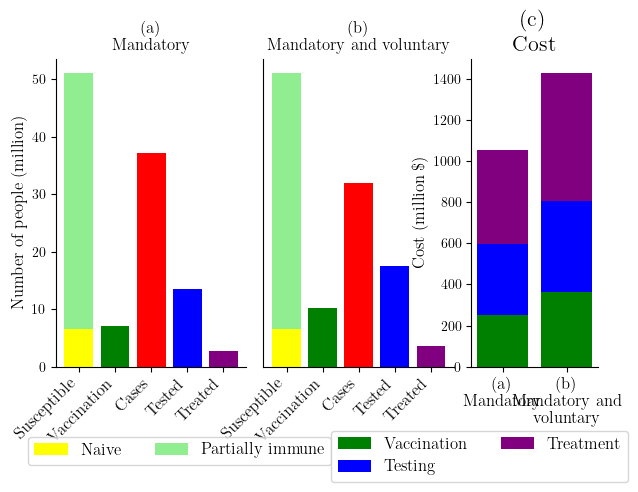

In [11]:
# Example placeholder data (replace with actual)
scenarios = ['(a)\n Mandatory', '(b) \n Mandatory and voluntary']
#stacked_susceptible_popn = [stacked_susceptible_popn[1], stacked_susceptible_popn[0]]
stacked_susceptible_naive = [stacked_susceptible_popn[1], stacked_susceptible_popn[1]]
stacked_susceptible_immune = [stacked_susceptible_popn[0], stacked_susceptible_popn[0]]
# stacked_vaccination = [80, 120]
# stacked_cumcases = [60, 70]
# stacked_testing = [40, 50]
# stacked_treatment = [30, 40]

# Cost breakdown
# stacked_man_costs = [10, 20, 30]
# stacked_man_vol_costs = [15, 25, 35]
cost_label = ['Vaccination', 'Testing', 'Treatment']
color_man = ['green', 'blue', 'purple']
bar_width = 0.4
cost_x_label = ['(a)\n Mandatory', '(b)\n Mandatory and \n voluntary']

color_mapping = {
    'Naive': 'yellow',
    'Partially immune': '#90EE90',
    'Vaccination': 'green',
    'Cases': 'red',
    'Tested': 'blue',
    'Treated': 'purple',
}

# Set up figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(7, 4), gridspec_kw={'width_ratios': [1.5, 1.5, 1], 'wspace': 0.1})

# --- First 2 panels: scenarios A and B ---
for i, ax in enumerate(axs[:2]):
    scenario = scenarios[i]
    
    # Stack susceptible
    bottom_val = 0
    ax.bar('Susceptible', stacked_susceptible_immune[i], bottom=bottom_val, color=color_mapping['Naive'], label='Naive')
    bottom_val += stacked_susceptible_immune[i]
    ax.bar('Susceptible', stacked_susceptible_naive[i], bottom=bottom_val, color=color_mapping['Partially immune'], label='Partially immune')

    # Other categories
    ax.bar('Vaccination', stacked_vaccination[i], color=color_mapping['Vaccination'])
    ax.bar('Cases', stacked_cumcases[i], color=color_mapping['Cases'])
    ax.bar('Tested', stacked_testing[i], color=color_mapping['Tested'])
    ax.bar('Treated', stacked_treatment[i], color=color_mapping['Treated'])

    ax.set_title(scenario, fontsize=12, fontweight='bold')
    ax.set_xticklabels(['Susceptible', 'Vaccination', 'Cases', 'Tested', 'Treated'],
                       rotation=45, ha="right", fontsize=12, fontweight="bold")
    if i==0:
        ax.set_ylabel('Number of people (million)', fontsize=12, fontweight="bold")

    if i > 0:
        ax.set_yticks([])
ax.legend(bbox_to_anchor=(0.4, -0.2), ncol=2, fontsize=12)
# --- Third panel: cost breakdown ---
ax = axs[2]
for j in range(3):
    b1 = sum(stacked_man_costs[:j])
    b2 = sum(stacked_man_vol_costs[:j])

    ax.bar(0, stacked_man_costs[j], width=bar_width, bottom=b1, color=color_man[j], label=cost_label[j])
    ax.bar(1.25 * bar_width, stacked_man_vol_costs[j], width=bar_width, bottom=b2, color=color_man[j])

ax.set_xticks([0, 1.25 * bar_width])
ax.set_xticklabels(cost_x_label, fontsize=12, fontweight="bold")
ax.set_ylabel('Cost (million \$)', fontsize=12, fontweight="bold")
ax.set_title('(c)\n Cost', fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.3, -0.18), ncol=2, fontsize=12)

# Remove spines for aesthetics
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig('care_seeking_and_cost_three_panel_figure.pdf', bbox_inches='tight', dpi=600)
plt.savefig("Fig1.eps", format='eps', dpi=300)
plt.show()
